# ImmoCheck

This projects purpose is to give an overview how rent and buying prices of real estate changed in vienna over the last years. Therefore certain steps are taken. First of all data gets imported and gathered through different sources. Futher cleaning and stucturing will also be apllied. The main parts like data explanation, analysis and also visulations for better understanding will give you a better understanding on the topic. In the last part, conslusions will be drwan. The cleaned and stuctured data will also be provided as csv files. \
Let's get started!

## Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## Data Gathering

There will be four different sources of data. One Webscarping, one API and two files.

### Webscarping - Cost of real estate

To get data regarding current costs of real estate, data from the webside "Immobilienscout24.at" will be scraped.

In [2]:
i = 1
url = ""
prices = []
while True:
    if i == 1:
        url = 'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen'
    else:
        url = f'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-{i}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    postings = soup.find_all('li', {'class': 'Item-item-S33'})
    i += 1
    scraped_vals = 0
    for ele in postings:
        for ele2 in (ele.select('a > section > section:nth-of-type(2) > ul:nth-of-type(1) > li:nth-of-type(2)')):
            prices.append(ele2.getText())
            scraped_vals += 1
    if postings == []:
        break;

    print(url,' scraped values:',scraped_vals)

https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-2  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-3  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-4  scraped values: 12
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-5  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-6  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-7  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-8  scraped values: 13
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-9  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-10  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnu

The scraped values get converted in a pandas dataFrame.

In [3]:
export_dict = {'vals':prices}
export_df = pd.DataFrame(export_dict)
export_df.head(10)

,vals
0,"ab 5.614,27 €/m²"
1,"ab 7.800,97 €/m²"
2,"ab 5.847,55 €/m²"
3,"ab 6.279,51 €/m²"
4,"ab 5.171,14 €/m²"
5,"ab 9.863,62 €/m²"
6,"ab 18.665,28 €/m²"
7,"ab 5.950,96 €/m²"
8,"ab 7.822,06 €/m²"
9,"ab 5.693,5 €/m²"


Looks good, but for further processing we just need the values.

In [4]:
export_df = export_df.replace('ab','',regex = True)
export_df = export_df.replace('€/m²','',regex = True)
export_df = export_df.replace(' ','',regex = True)
export_df.head(10)

,vals
0,"5.614,27"
1,"7.800,97"
2,"5.847,55"
3,"6.279,51"
4,"5.171,14"
5,"9.863,62"
6,"18.665,28"
7,"5.950,96"
8,"7.822,06"
9,"5.693,5"


Now the format has to be adapted.

In [5]:
export_df = export_df.apply(lambda x: x.str.replace('.',''))
export_df = export_df.apply(lambda x: x.str.replace(',','.'))
export_df.head(10)

,vals
0,5614.27
1,7800.97
2,5847.55
3,6279.51
4,5171.14
5,9863.62
6,18665.28
7,5950.96
8,7822.06
9,5693.5


Most of the values look good. However, wile scarping we also got some value which can not be further processed.

In [6]:
export_df[export_df['vals'].str.startswith('statt')]

,vals
253,statt215000€-7%
365,statt250000€-4%
398,statt330000€-3%
404,statt479000€-6%


These values get deleted.

In [7]:
export_df = export_df.drop([185,393,527,553])

KeyError: '[527, 553] not found in axis'

Now the value look good and are ready to be exported for later processing.

In [8]:
export_df.to_csv('./exports/prices.csv', index=False)  

### Datasource 2 - Cost of renting an apartment

#### To get historical data regarding costs of renting an apartment in Vienna, data in form of .ods files from the website "statistik.at" is used.

In [14]:
!pip install pdfplumber pandas openpyxl odfpy

     ---------------------------------------- 0.0/717.0 kB ? eta -:--:--
      --------------------------------------- 10.2/717.0 kB ? eta -:--:--
     - ----------------------------------- 30.7/717.0 kB 262.6 kB/s eta 0:00:03
     --- --------------------------------- 61.4/717.0 kB 409.6 kB/s eta 0:00:02
     --------- ---------------------------- 184.3/717.0 kB 1.0 MB/s eta 0:00:01
     -------------------------------------  716.8/717.0 kB 3.5 MB/s eta 0:00:01
     -------------------------------------- 717.0/717.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=137513 sha256=1441164f840d18fee05c84063154c8c521c5042a2ee2b76bef0d8a307a36117f
  Stored in directory: c:\users\smurh\appdata\local\pip\cache\wheels\d6\1d\c8\8c29be1d73ca42d15977c75193d9f39a98499413c2838ac54c
Successfully built odfpy


In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract the row with "Wien" from the ODS files and add the filename as a column
def extract_wien_data(file_path):
    data = pd.read_excel(file_path, engine='odf')
    wien_data = data[data.apply(lambda row: row.astype(str).str.contains('Wien').any(), axis=1)].copy() 
    wien_data.loc[:, 'Source File'] = file_path  # to assign the filename
    return wien_data

# ODS files 2015 to 2020
ods_files_2015_2020 = [
    "statistik austria/2015.ods",
    "statistik austria/2016.ods",
    "statistik austria/2017.ods",
    "statistik austria/2018.ods",
    "statistik austria/2019.ods",
    "statistik austria/2020.ods"
]

# ODS files 2021 and 2022
ods_files_2021_2022 = [
    "statistik austria/2021.ods",
    "statistik austria/2022.ods"
]

# Extract "Wien" data from 2015 to 2020
wien_data_list_2015_2020 = [extract_wien_data(file) for file in ods_files_2015_2020]
wien_data_list_2015_2020 = [df for df in wien_data_list_2015_2020 if not df.empty and not df.isna().all().all()]
combined_wien_data_2015_2020 = pd.concat(wien_data_list_2015_2020, ignore_index=True)
combined_wien_data_2015_2020 = combined_wien_data_2015_2020.drop_duplicates()
wien_column_values_2015_2020 = combined_wien_data_2015_2020[['Unnamed: 12', 'Source File']]

# Extract "Wien" data from 2021 and 2022
wien_data_list_2021_2022 = [extract_wien_data(file) for file in ods_files_2021_2022]
wien_data_list_2021_2022 = [df for df in wien_data_list_2021_2022 if not df.empty and not df.isna().all().all()]
combined_wien_data_2021_2022 = pd.concat(wien_data_list_2021_2022, ignore_index=True)
combined_wien_data_2021_2022 = combined_wien_data_2021_2022.drop_duplicates()
wien_column_values_2021_2022 = combined_wien_data_2021_2022[['Unnamed: 5', 'Source File']]

# Rename columns and combine both dataframes
wien_column_values_2015_2020.columns = ['Miete/m² in Wien', 'Source File']
wien_column_values_2021_2022.columns = ['Miete/m² in Wien', 'Source File']

combined_wien_all_years = pd.concat([wien_column_values_2015_2020, wien_column_values_2021_2022], ignore_index=True)

# Extract year from source file and add as a new column
combined_wien_all_years['Jahr'] = combined_wien_all_years['Source File'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Drop the source file column
combined_wien_all_years = combined_wien_all_years.drop(columns=['Source File'])

# Convert "Miete/m² in Wien" to a float and round to one decimal place
combined_wien_all_years['Miete/m² in Wien'] = combined_wien_all_years['Miete/m² in Wien'].astype(float).round(1)

# Error message "FutureWarning: (...) " can be ignored!

C:\Users\smurh\AppData\Local\Temp\ipykernel_13720\1623310260.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_wien_data_2015_2020 = pd.concat(wien_data_list_2015_2020, ignore_index=True)


In [57]:
# the combined data
print(combined_wien_all_years)

   Miete/m² in Wien  Jahr
0               5.2  2015
1               5.4  2016
2               5.7  2017
3               5.9  2018
4               6.1  2019
5               6.3  2020
6               6.3  2021
7               6.6  2022


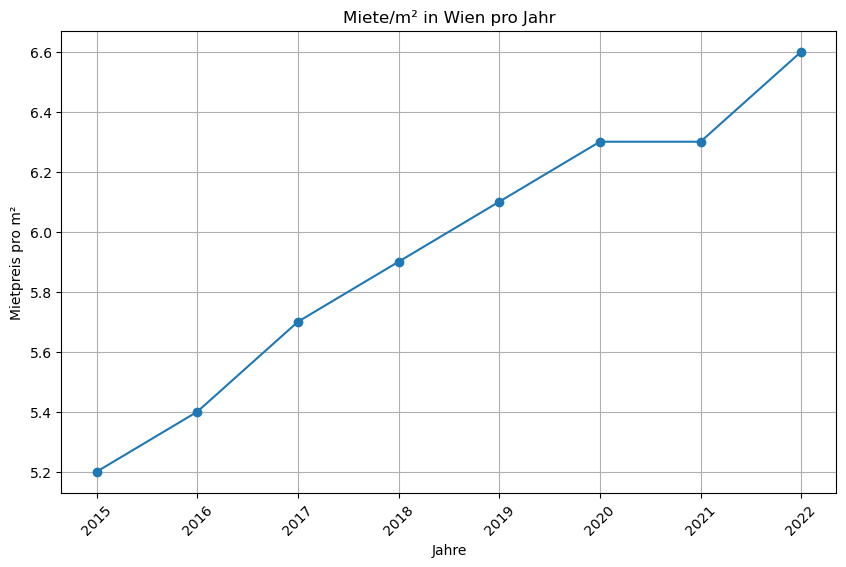

In [60]:
# Visualization with Line Plot
plt.figure(figsize=(10, 6))
plt.plot(combined_wien_all_years['Jahr'], combined_wien_all_years['Miete/m² in Wien'], marker='o')
plt.xlabel('Jahre')
plt.ylabel('Mietpreis pro m²')
plt.title('Miete/m² in Wien pro Jahr')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

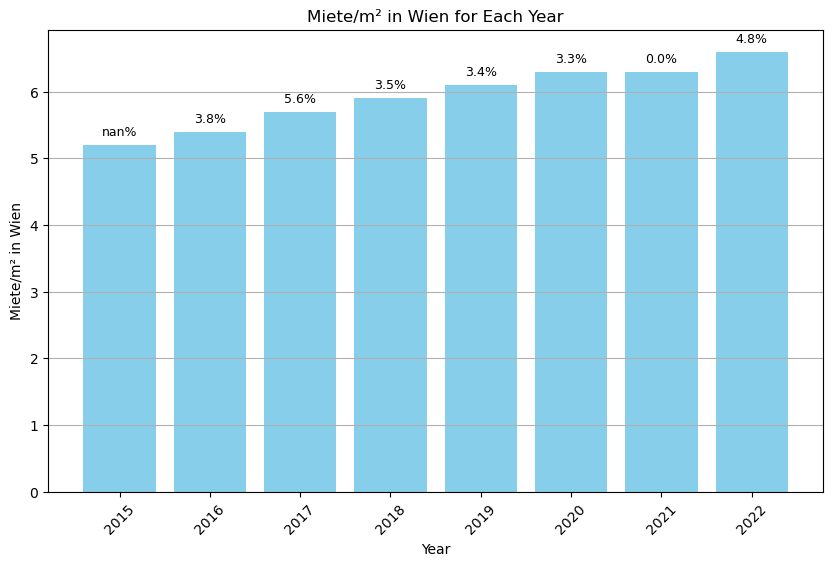

In [63]:
# Calculate the percentage change from year to year
combined_wien_all_years['Miete/m² in Wien'] = combined_wien_all_years['Miete/m² in Wien']
combined_wien_all_years['Prozentuale Veränderung'] = combined_wien_all_years['Miete/m² in Wien'].pct_change().mul(100).round(1)

# Visualization with Bar Chart 
plt.figure(figsize=(10, 6))
plt.bar(combined_wien_all_years['Jahr'], combined_wien_all_years['Miete/m² in Wien'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Miete/m² in Wien')
plt.title('Miete/m² in Wien for Each Year')
plt.grid(axis='y')
plt.xticks(rotation=45)

# Add percentage change as text above the bars
for i, (year, value, change) in enumerate(zip(combined_wien_all_years['Jahr'], combined_wien_all_years['Miete/m² in Wien'], combined_wien_all_years['Prozentuale Veränderung'])):
    plt.text(i, value + 0.1, f'{change}%', ha='center', va='bottom', fontsize=9)

plt.show()